In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import cv2
import math
import random
import keras
from sklearn import preprocessing

matplotlib.rcParams['figure.figsize'] = [12, 12]

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "all_patches_list_fastest.npy")
LABELS_FILE = os.path.join(POET_DIR, "all_labels_list_fastest.npy")
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
GAZE_POINTS = 5
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [3]:
%pwd

'D:\\data\\POETdataset'

# LOAD DATA

In [4]:
x = np.load(PATCHES_FILE)

In [5]:
y = np.load(LABELS_FILE)

In [6]:
class2idx = np.load(CLASS2IDX_FILE).tolist()

In [7]:
idx2class = np.load(IDX2CLASS_FILE).tolist()

## CHECKING DATA

In [8]:
len(x)

6173

In [9]:
len(y)

6173

In [10]:
x[0].shape

(5, 32, 32, 3)

In [11]:
x[:,:].min(), x[:,:].max()

(0.0, 255.0)

In [12]:
idx2class[3]

'cat'

In [13]:
class2idx['cat']

3

# DATA EXPLORATION

## IMBALANCED DATASET

(array([ 663.,  535.,  501., 1049.,  301.,  458., 1255.,  480.,  509.,
         422.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

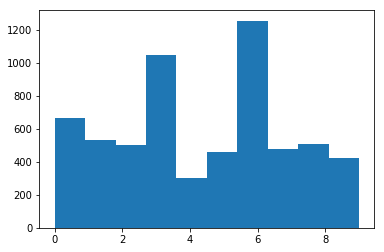

In [14]:
plt.hist(y,bins=len(idx2class))

# Extract features for patches

Now using the preprocessing function!!!!!!!!!

In [15]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(PATCH_SIZE,PATCH_SIZE,3)))
features_extractor_model.add(learned_model)

In [16]:
x = x.reshape((x.shape[0]*GAZE_POINTS,PATCH_SIZE,PATCH_SIZE,3))
xtrain = features_extractor_model.predict(x)

In [17]:
xtrain = xtrain.reshape((x.shape[0]//GAZE_POINTS,GAZE_POINTS,xtrain.shape[1]))

In [18]:
xtrain.shape

(6173, 5, 2048)

## ONE HOT ENCODER

In [19]:
ytrain = y

In [20]:
from sklearn.preprocessing import OneHotEncoder


In [21]:
enc = OneHotEncoder(handle_unknown='ignore')

In [22]:
ytrain = ytrain.reshape((-1,1))

In [23]:
enc.fit(ytrain)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [24]:
ytrain = enc.transform(ytrain)

In [25]:
ytrain[22].argmax()

0

In [26]:
ytrain.shape, xtrain.shape

((6173, 10), (6173, 5, 2048))

# MODEL TRAINING

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain.todense(), test_size=0.1, stratify=ytrain.todense())

## MODEL DEFINITION

In [41]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, dropout=0.5, input_shape=(GAZE_POINTS, xtrain.shape[2],)))
    model.add(keras.layers.Dense(len(idx2class), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
    print(model.summary())
    return model

In [42]:
import time
model_id = str(int(time.time()))
os.mkdir(model_id)

In [43]:
filepath=os.path.join(model_id,"weights-imbalanced-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [44]:
model = get_model()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=1,
#     batch_size=64,
    epochs=50,
    callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                266368    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 266,698
Trainable params: 266,698
Non-trainable params: 0
_________________________________________________________________
None
Train on 5555 samples, validate on 618 samples
Epoch 1/50
5555/5555 [==============================] - 4s 755us/step - loss: 1.8701 - acc: 0.3275 - val_loss: 1.5921 - val_acc: 0.4563

Epoch 00001: val_acc improved from -inf to 0.45631, saving model to 1542639680\weights-imbalanced-01-0.46.hdf5
Epoch 2/50
5555/5555 [==============================] - 3s 473us/step - loss: 1.5587 - acc: 0.4450 - val_loss: 1.4810 - val_acc: 0.4887

Epoch 00002: val_acc improved from 0.45631 to 0.48867, saving model to 1542639680\weights-imbal

In [45]:
from keras.utils import plot_model

In [46]:
plot_model(model, to_file=os.path.join(model_id, 'model.png'), show_shapes=True)

In [47]:
total_summary=""
from shutil import copyfile

def add_to_summary(line):
    global total_summary
    total_summary += "%s\n" %line

def savesummary():
    global total_summary
    path = os.path.join(model_id, "summary.txt")
    with open(path,'w') as f:
        f.writelines(total_summary)
        f.writelines("\nUsed %s" %PATCHES_FILE)
    print('saving summary to ', path)
    copyfile("data_note.txt", os.path.join(model_id, "data_note.txt"))

In [48]:
model.summary(print_fn=add_to_summary)
savesummary()

saving summary to  1542639680\summary.txt


# Plot model history

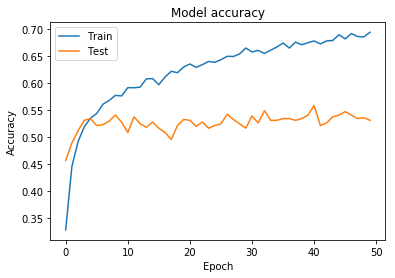

<Figure size 432x288 with 0 Axes>

In [49]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gcf().savefig(os.path.join(model_id, "accuracy.png"))
plt.show()
plt.clf()

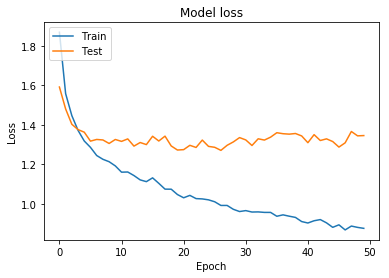

In [50]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(model_id, "loss.png"))
plt.show()

# Confusion matrix

Normalized confusion matrix


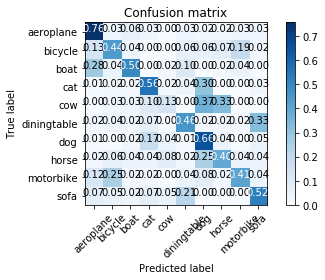

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

from sklearn.metrics import confusion_matrix

y_pred_proba = model.predict(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

import itertools

fig = plot_confusion_matrix(cnf_matrix, class2idx.keys(), normalize=True)


In [52]:
np.save(os.path.join(model_id, 'model-cnf_matrix'), cnf_matrix)
fig.savefig(os.path.join(model_id, 'model-cnf_matrix.png'))

## BALANCED CLASSES

In [ ]:
from scipy import stats

In [ ]:
freq = stats.itemfreq(y)
freq

In [ ]:
MIN_CLASS = np.min(freq, axis=0)[1]

MIN_CLASS

In [ ]:
xtrain_bal = np.zeros((MIN_CLASS*10, MAX_GAZE_POINTS, VGG_NR_FEATURES))
ytrain_bal = np.zeros((MIN_CLASS*10))
counts = {k:0 for k in idx2class.keys()}

In [ ]:
global_counter = 0
for i, ins in enumerate(xtrain):
    class_of_ins = y[i]
    if counts[class_of_ins] < MIN_CLASS:
        xtrain_bal[global_counter] = ins
        ytrain_bal[global_counter] = class_of_ins
        counts[class_of_ins] += 1
        global_counter += 1


In [ ]:
stats.itemfreq(ytrain_bal)

## MODEL

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
ytrain_bal = ytrain_bal.reshape((-1,1))

In [ ]:
enc.fit(ytrain_bal)

In [ ]:
ytrain_bal = enc.transform(ytrain_bal)

In [ ]:
ytrain_bal[22].argmax()

In [ ]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
    model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))

    optm = keras.optimizers.rmsprop(lr=0.00001, )
    model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
filepath="bal_weights_rms-64layers-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
model = get_model()
model.fit(
  xtrain_bal,
  ytrain_bal,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=50,
  callbacks=[checkpoint]
)